<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Bayesian optimisation of SVM hyperparameters



# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
from matplotlib import rc
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = 15, 8
rcParams['font.size'] = 20

# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Import external scripts
<hr style = "border:2px solid black" ></hr>

In [2]:
# Load the Python scripts that contain the Bayesian optimization code
%load_ext autoreload
%autoreload 2

%run ./gp.py
%run ./plotters.py

# Generate dataset
<hr style = "border:2px solid black" ></hr>


- To see how this algorithm behaves, we'll use it on a classification task.
- We'll use `make_classification()`, to build dummy data sets that can be used to test classifiers.
- Our idea is to use a Bayesian optimisation to optimise the value of some hyperparameters.
- We'll optimize the penalization parameter $C$, and kernel parameter $\gamma$, of a support vector machine, with RBF kernel. 
- The loss function we will use is the cross-validated area under the curve (AUC), based on three folds.



In [3]:
data, target = make_classification(n_samples=700,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)


def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()


- Because this is a relatively simple problem, we can actually compute the loss surface as a function of $C$ and $\gamma$. 
- This way, we can get an accurate estimate of where the true optimum of the loss surface is.



In [4]:
# We create a list of possible values the two hyperparameters can take
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

In [5]:
# The maximum is at:
minimum = param_grid[np.array(real_loss).argmax(), :]
print("Minimum is at: ", minimum)
print("Max value of the objective function", max(np.array(real_loss)))

Minimum is at:  [ 0.375      -2.15789474]
Max value of the objective function 0.9628880330224573


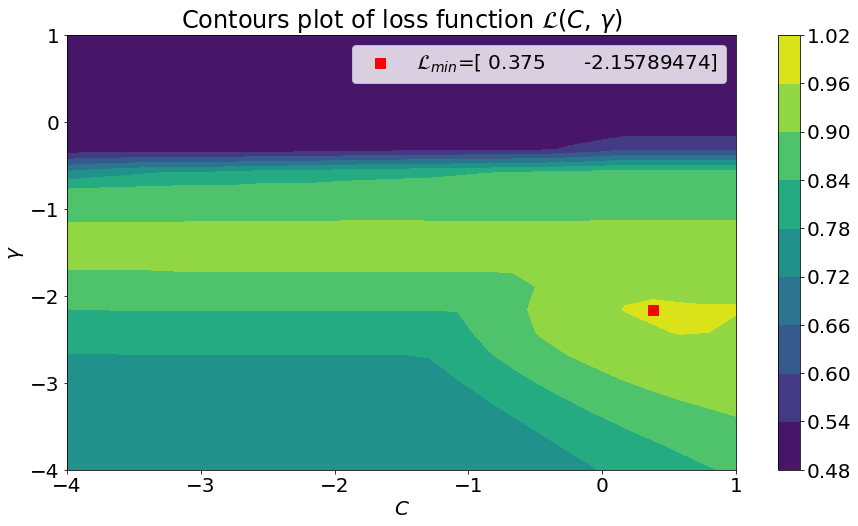

In [6]:
C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.plot(minimum[0], minimum[1], "rs", ms = 10, label = "$\mathcal{L}_{min}$=" + str(minimum))
plt.title('Contours plot of loss function $\mathcal{L}$($C$, $\gamma$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma$')
plt.legend()
plt.show()


- For the underlying GP, we'll assume a [Matern](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) kernel as the covariance function. 
- Although we skim over the selection of the kernel here, in general the behaviour of the algorithm is dependent on the choice of the kernel. 
- Using a Matern kernel, with the default parameters, means we implicitly assume the loss $f$ is at least once differentiable. 
- [There are a number of kernels available](http://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) in scikit-learn, and each kernel implies a different assumption on the behaviour of the loss $f$.



In [7]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters = 50, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

In [8]:
print("Minimum is at:                 :", minimum)
print("Minimum found by the optimiser :", xp[-1])
print("==================================")
print("Max value of the objective function                  : ", max(np.array(real_loss)))
print("Max value of the objective function found by optimser: ", yp[-1])

Minimum is at:                 : [ 0.375      -2.15789474]
Minimum found by the optimiser : [ 0.46208715 -2.21601913]
Max value of the objective function                  :  0.9628880330224573
Max value of the objective function found by optimser:  0.9628901144096936


The animation below shows the sequence of points selected, if we run the Bayesian optimization algorithm in this setting. The star shows the value of $C$ and $\gamma$ that result in the largest value of cross-validated AUC.

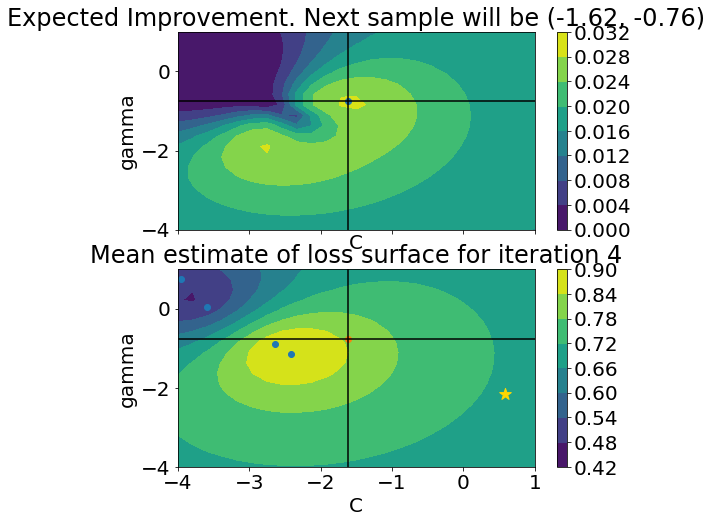

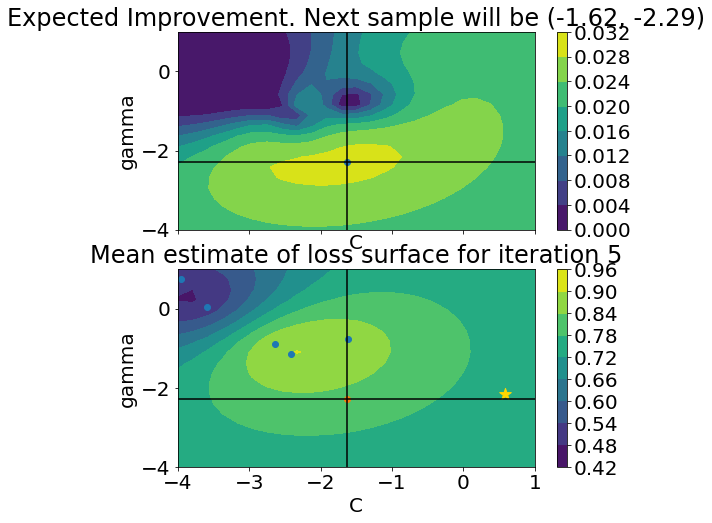

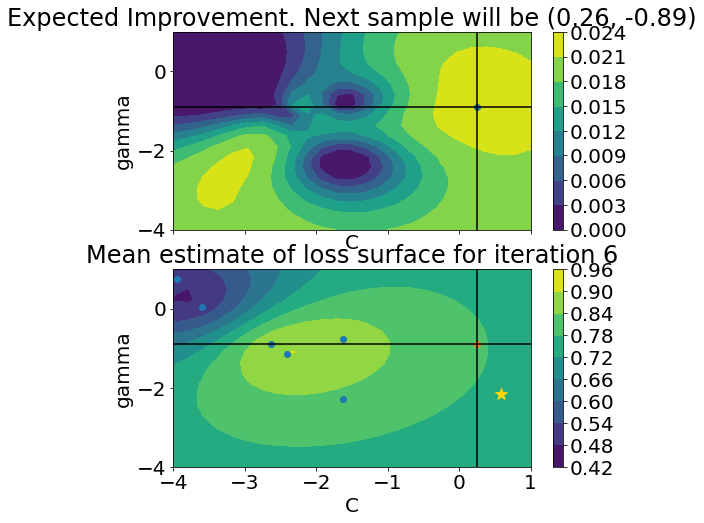

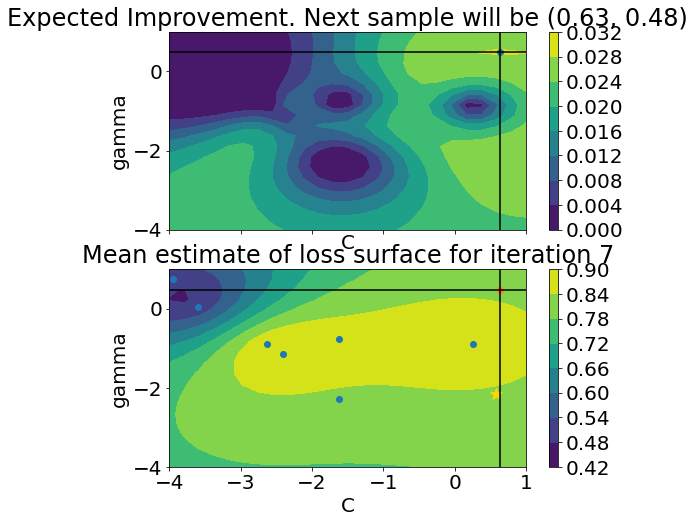

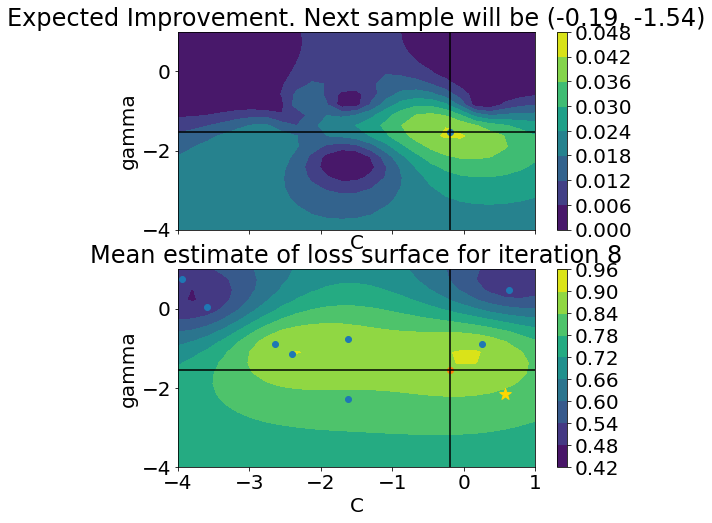

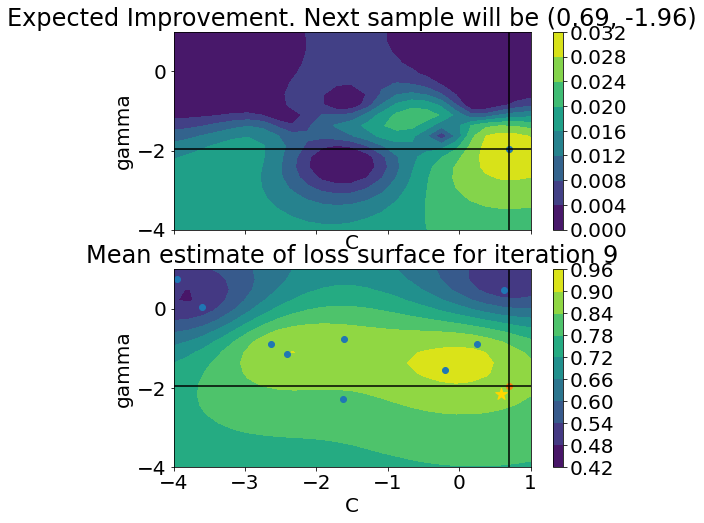

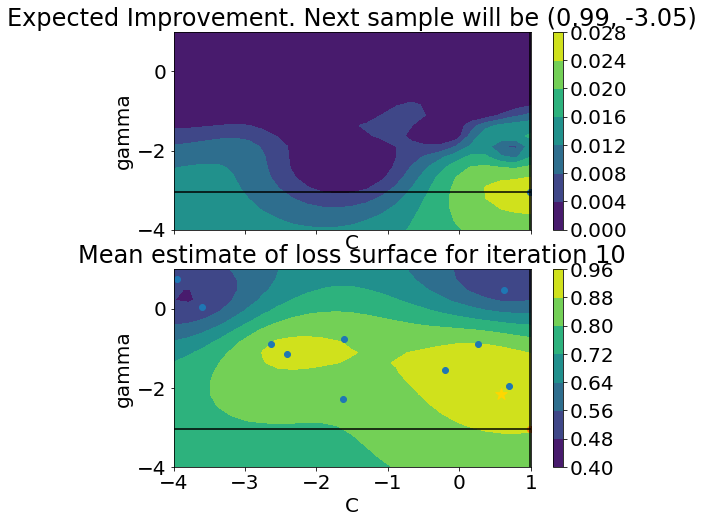

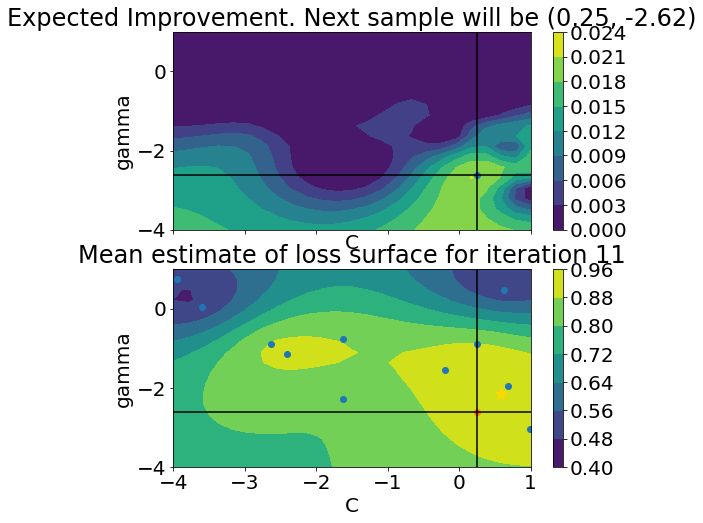

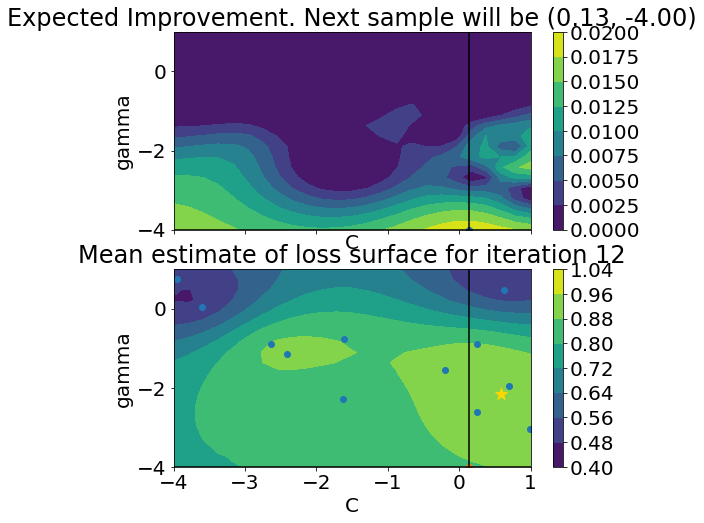

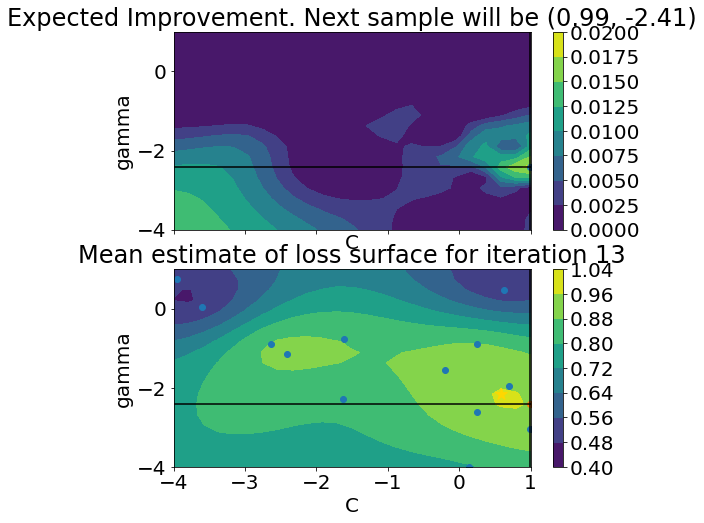

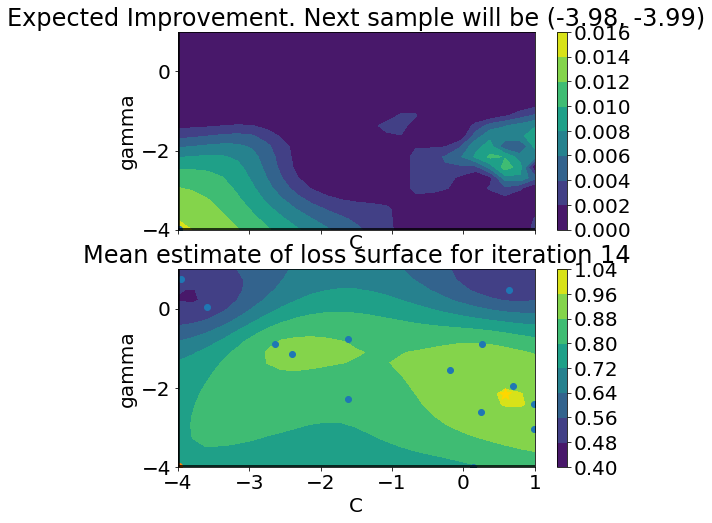

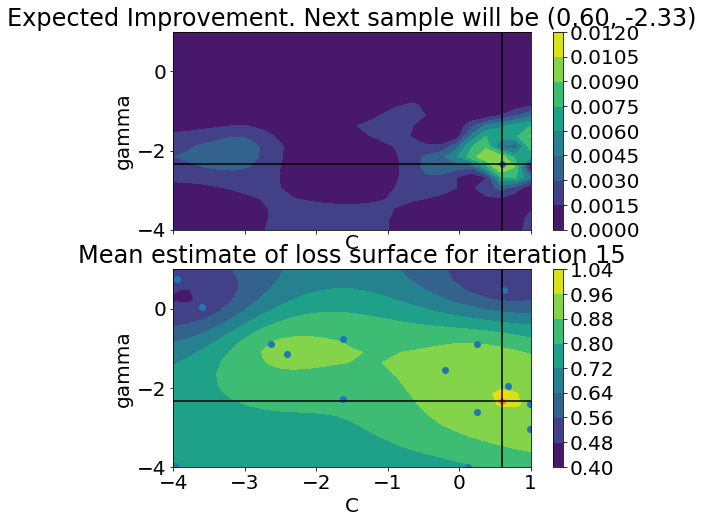

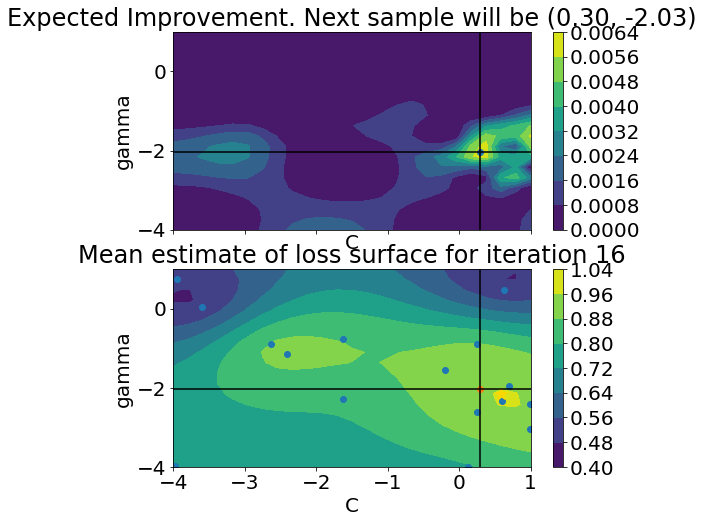

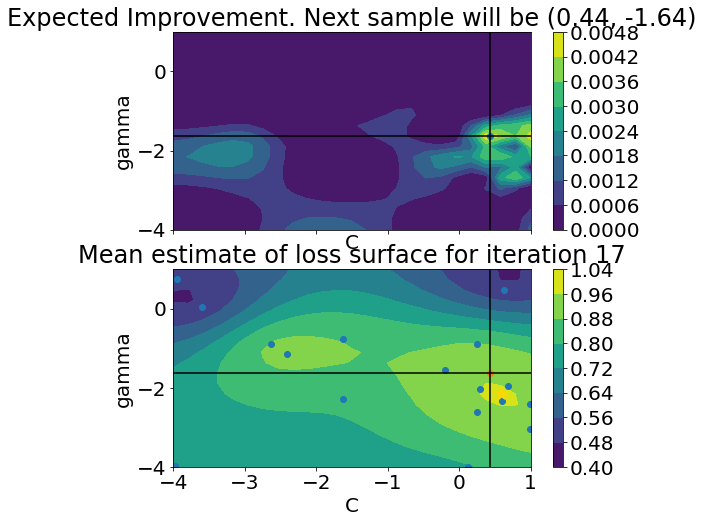

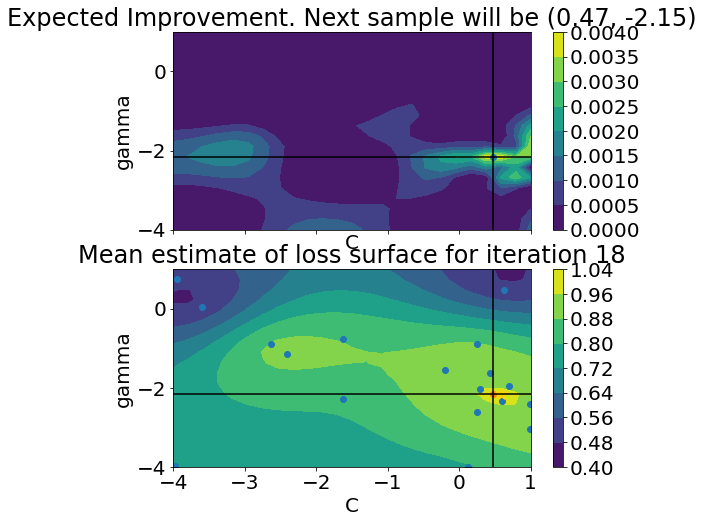

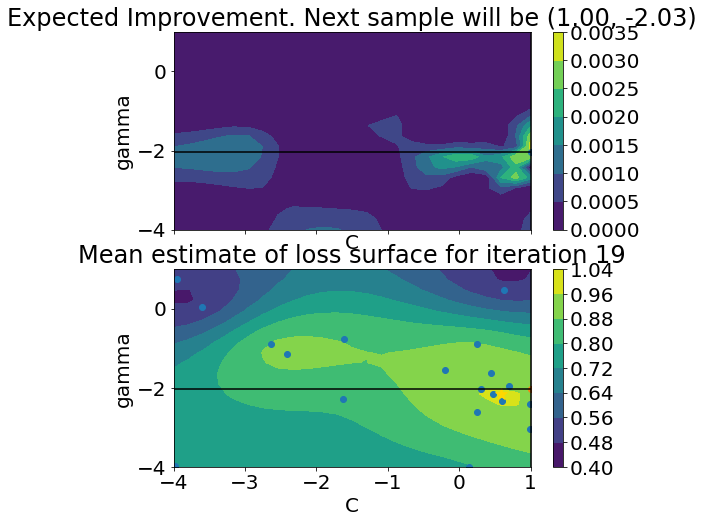

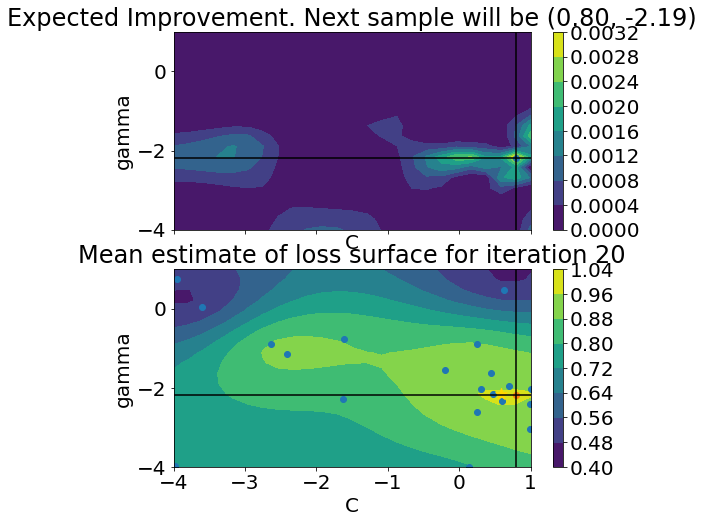

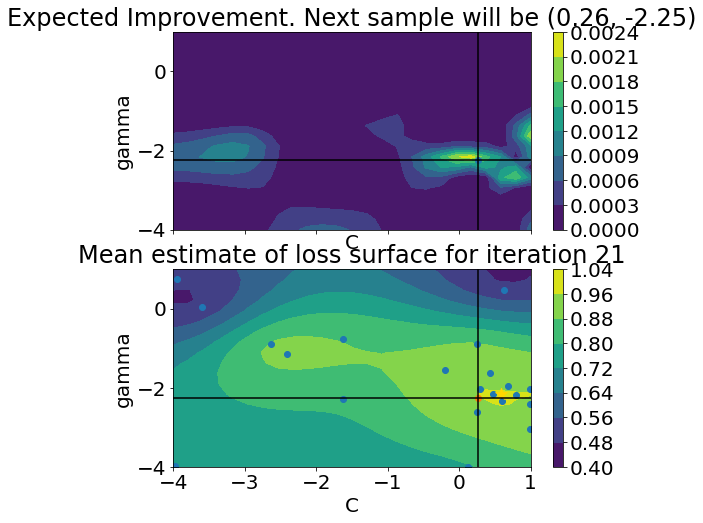

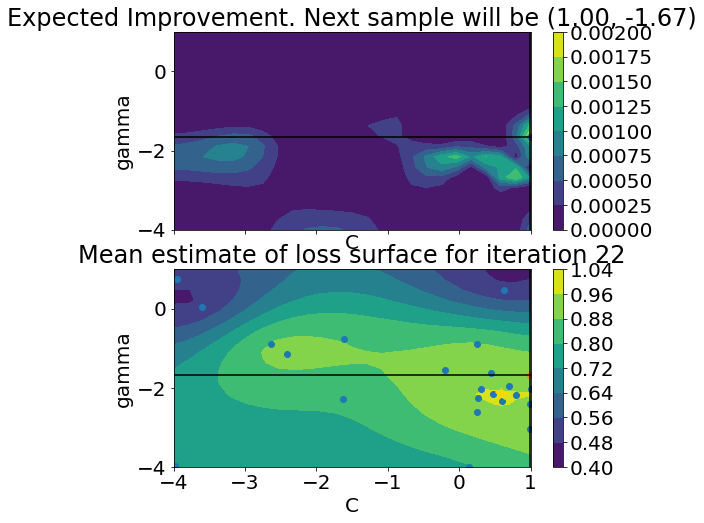

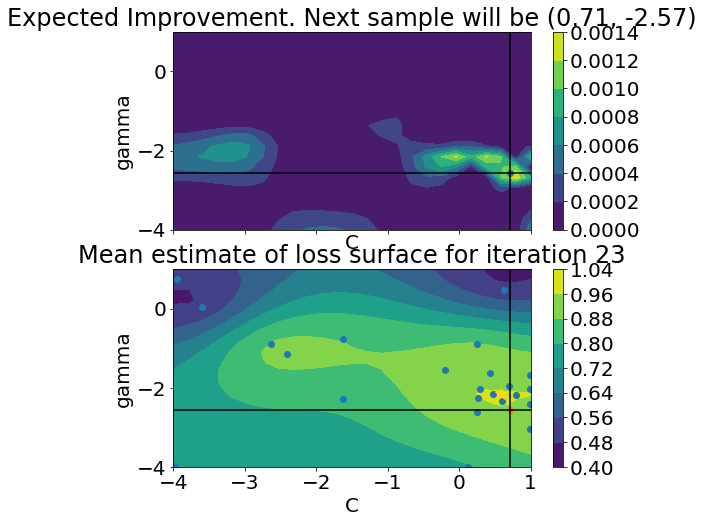

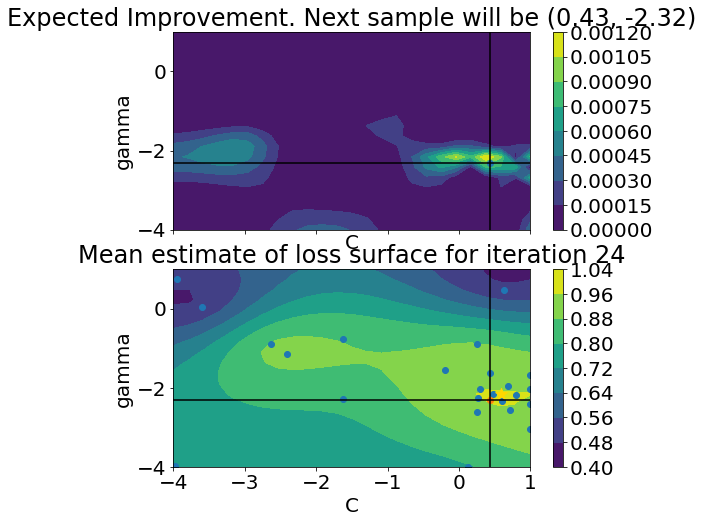

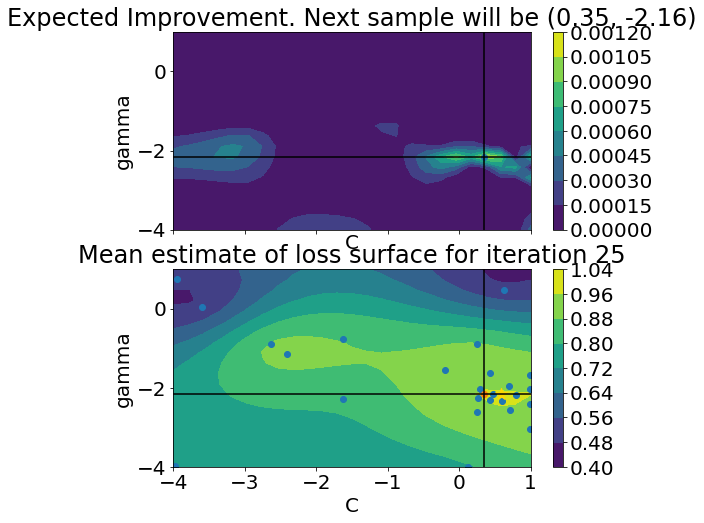

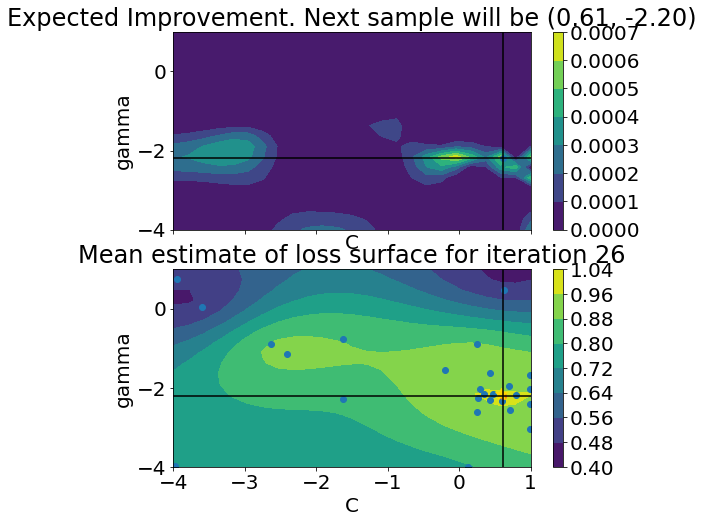

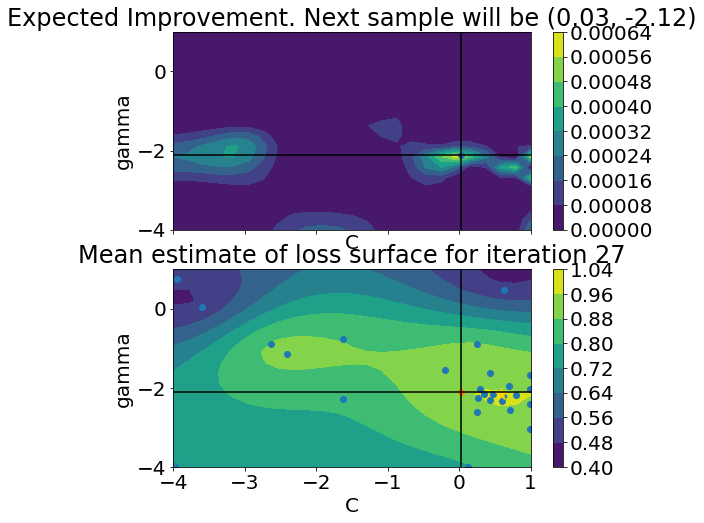

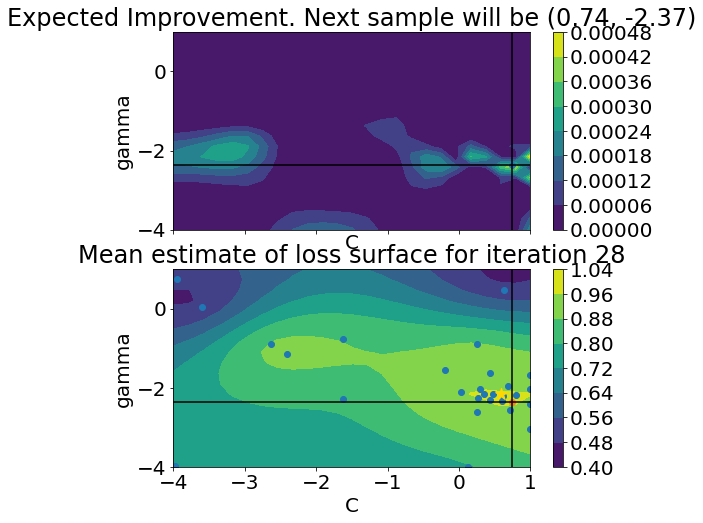

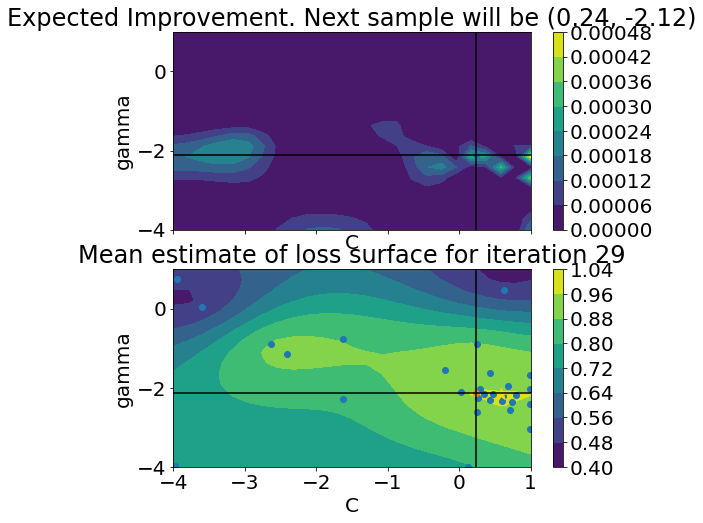

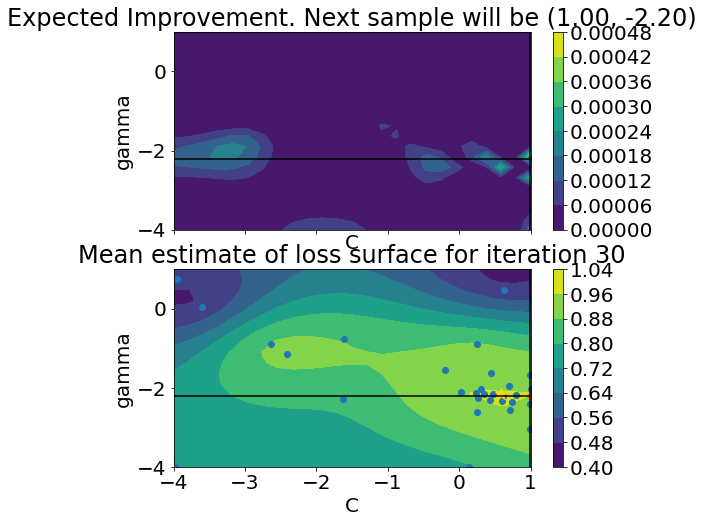

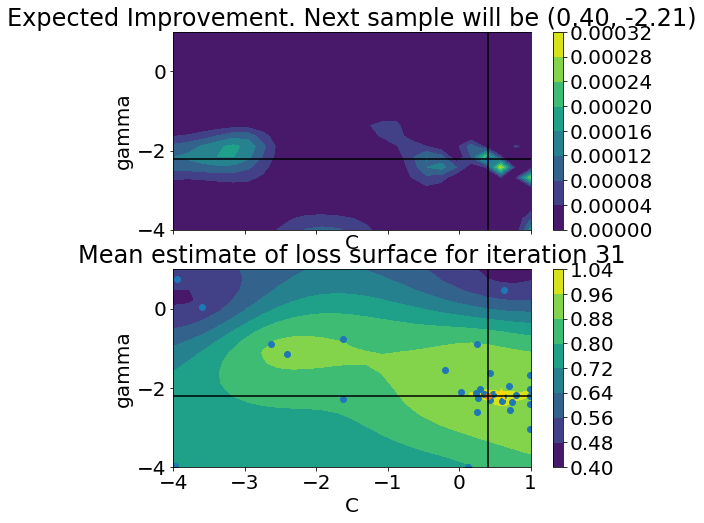

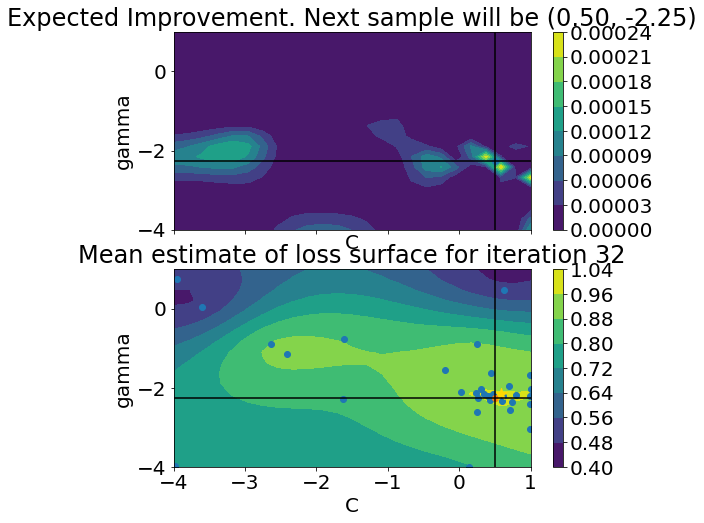

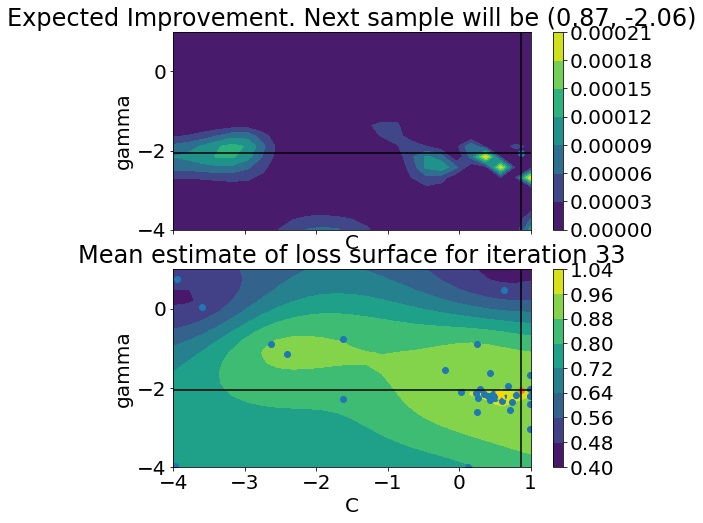

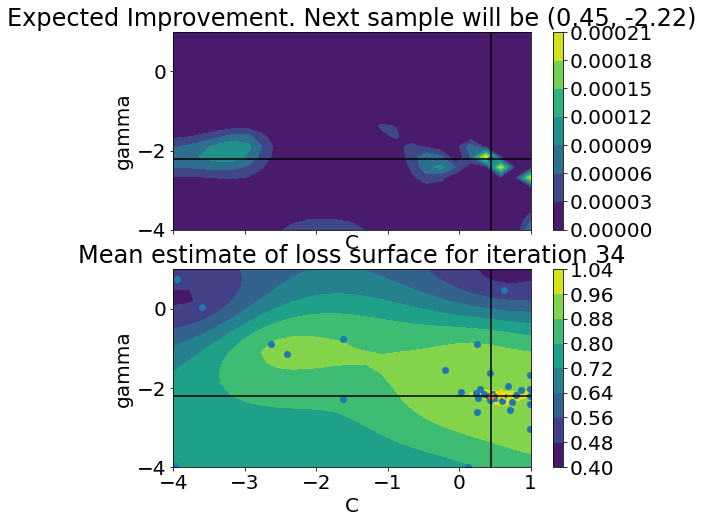

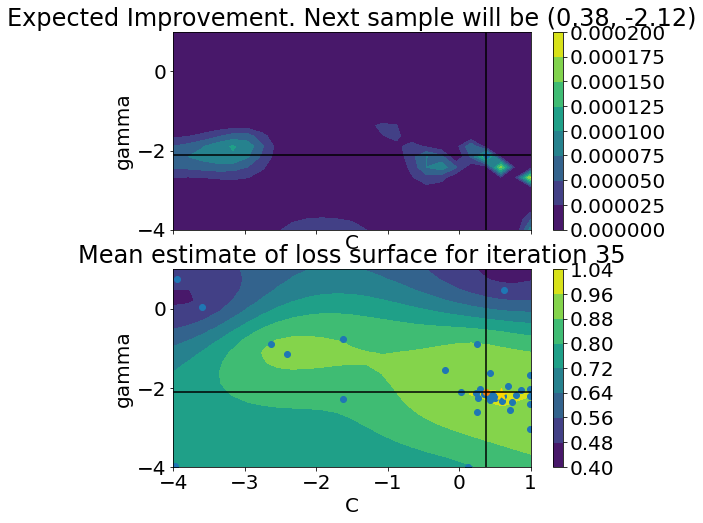

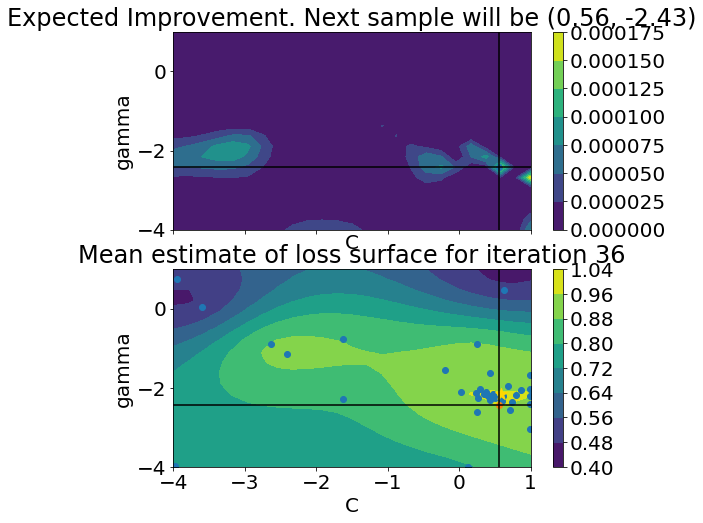

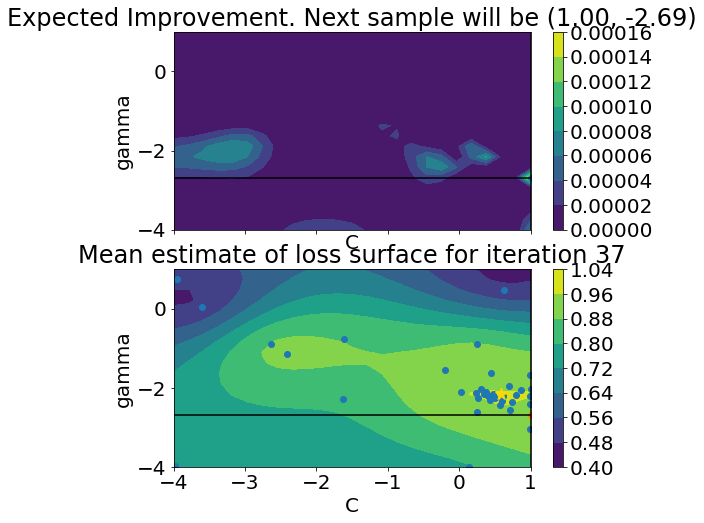

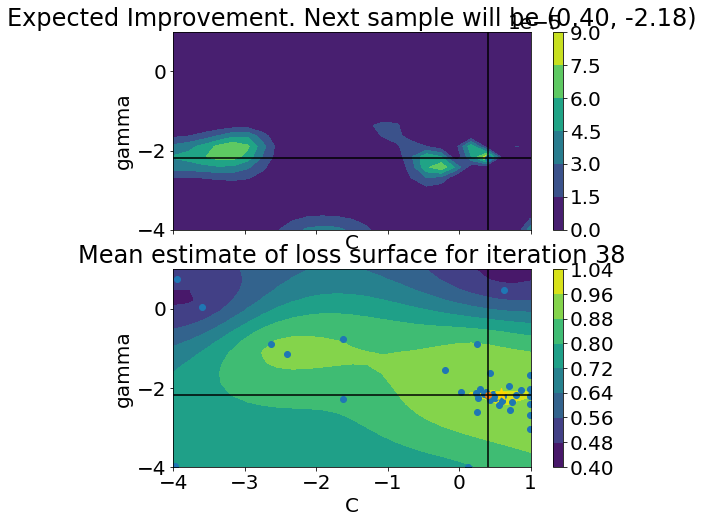

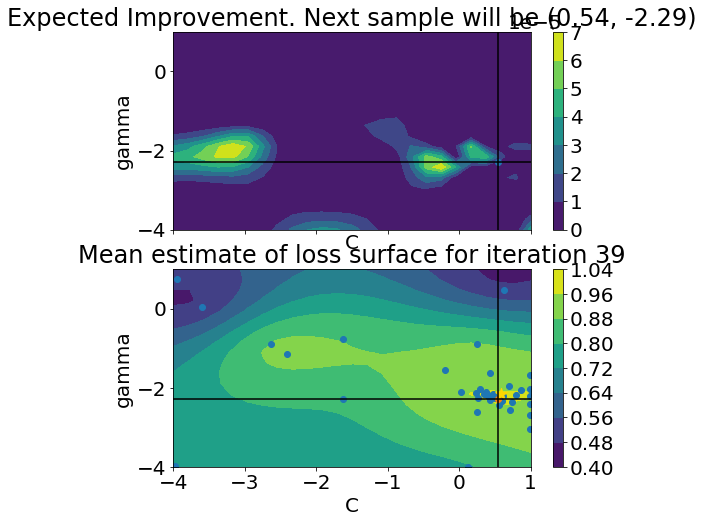

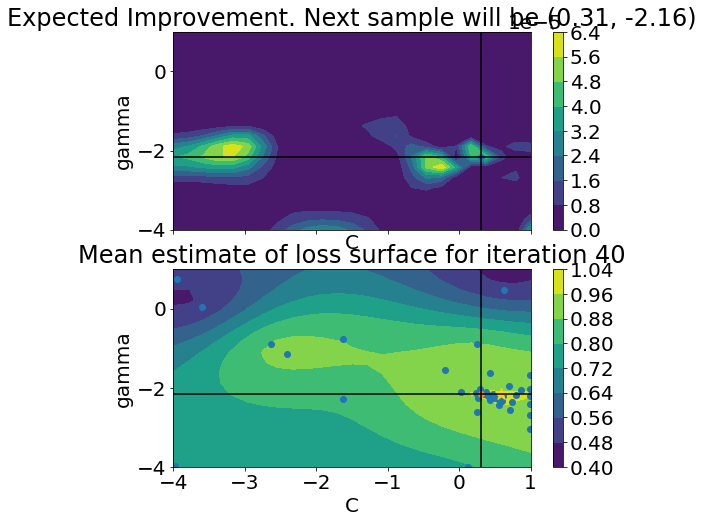

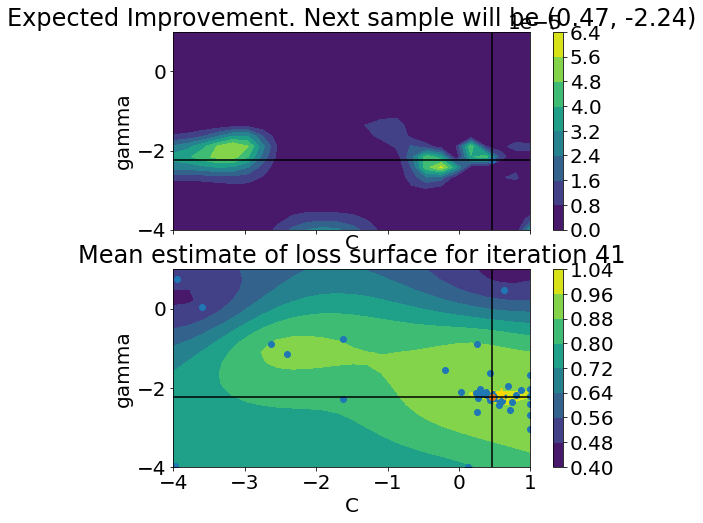

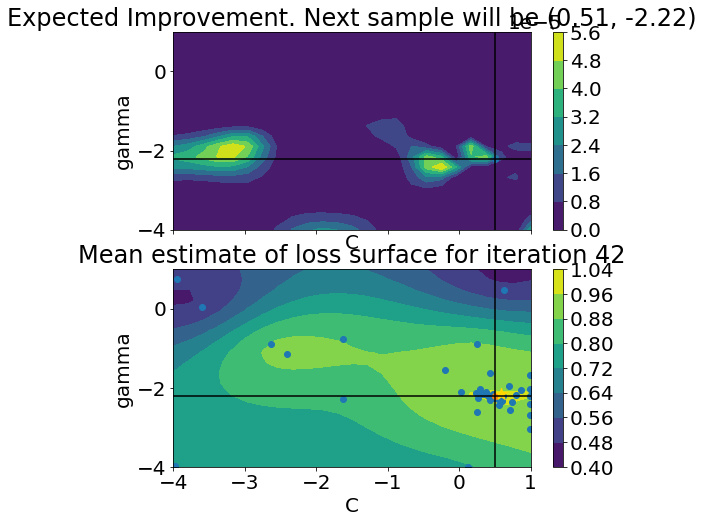

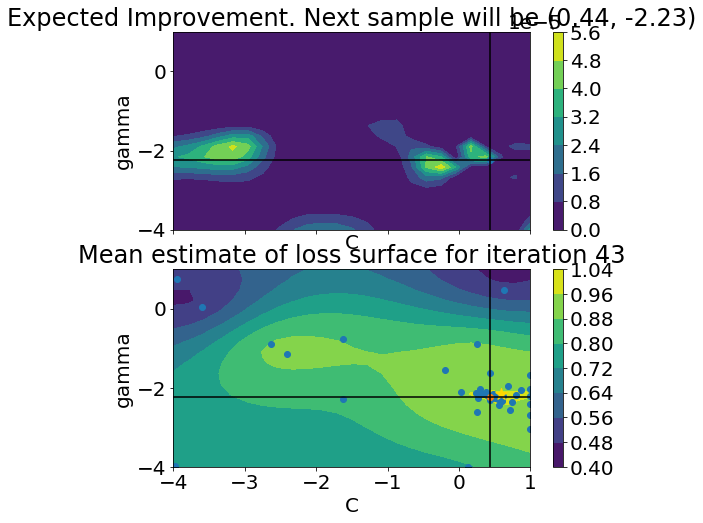

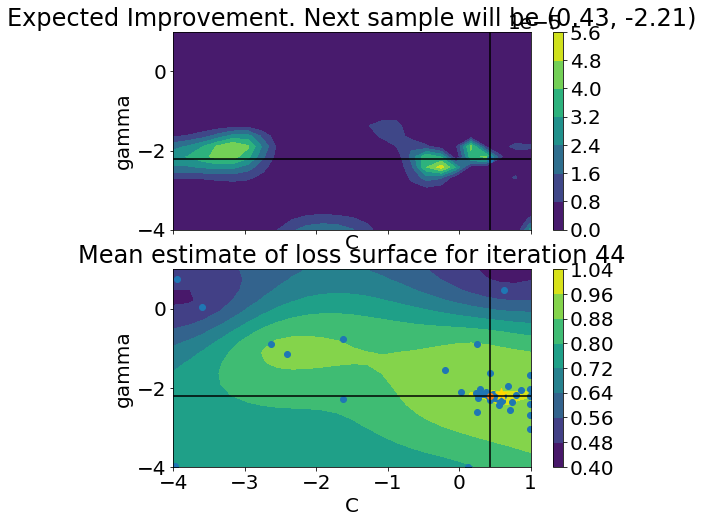

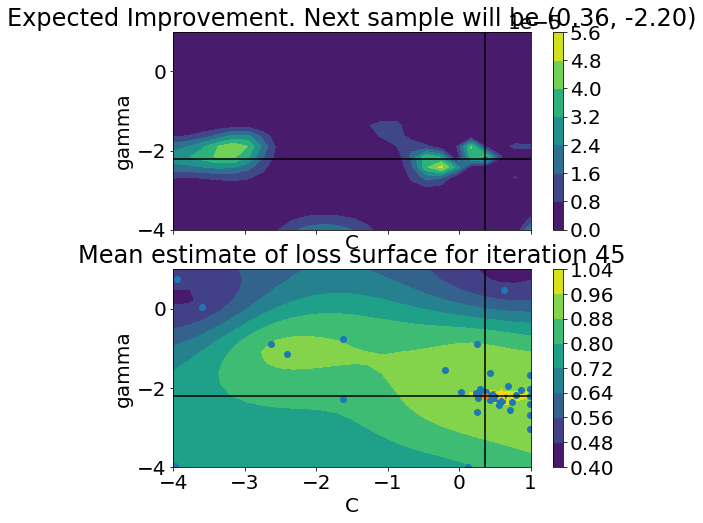

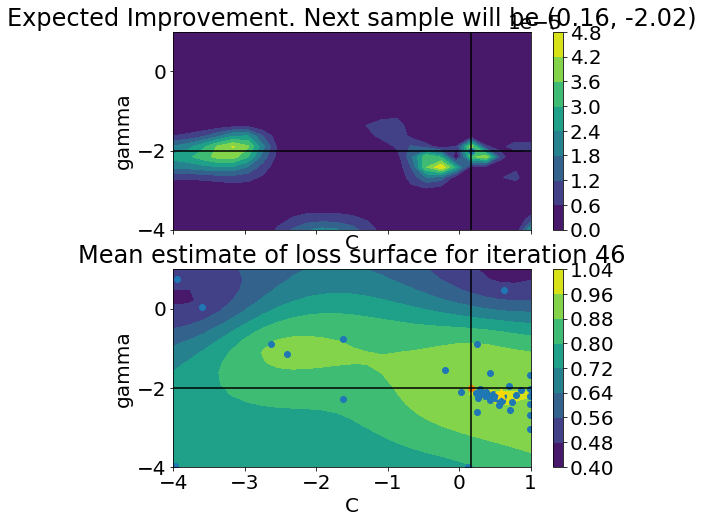

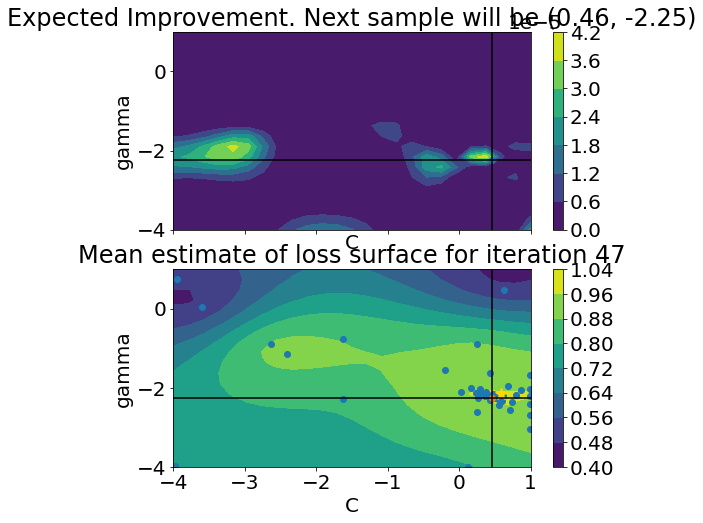

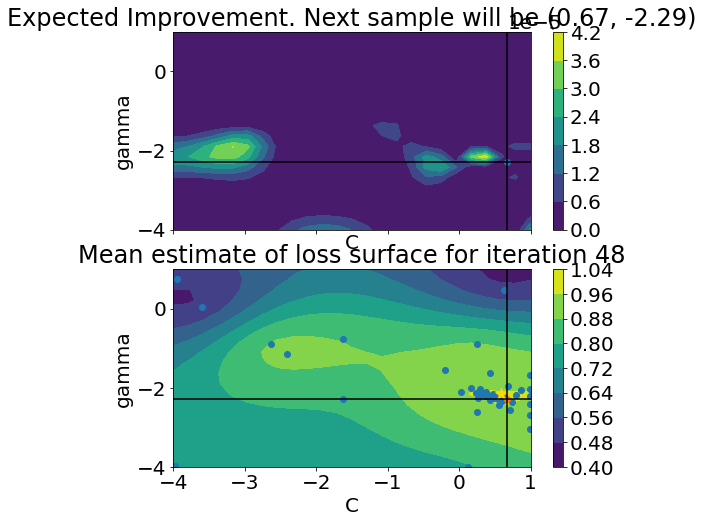

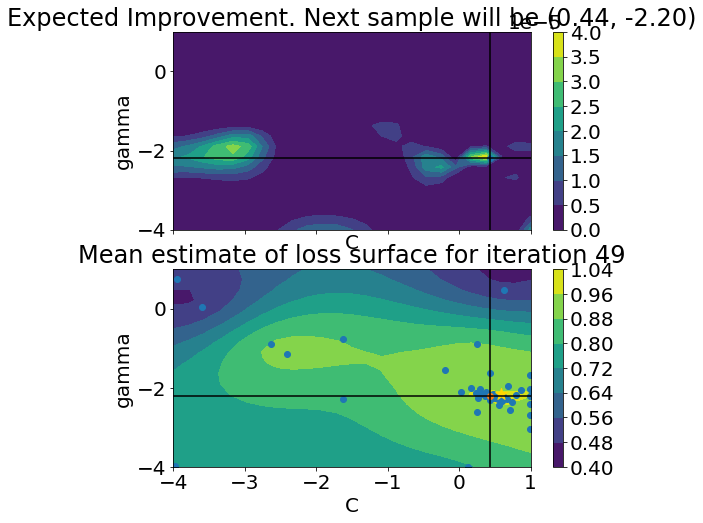

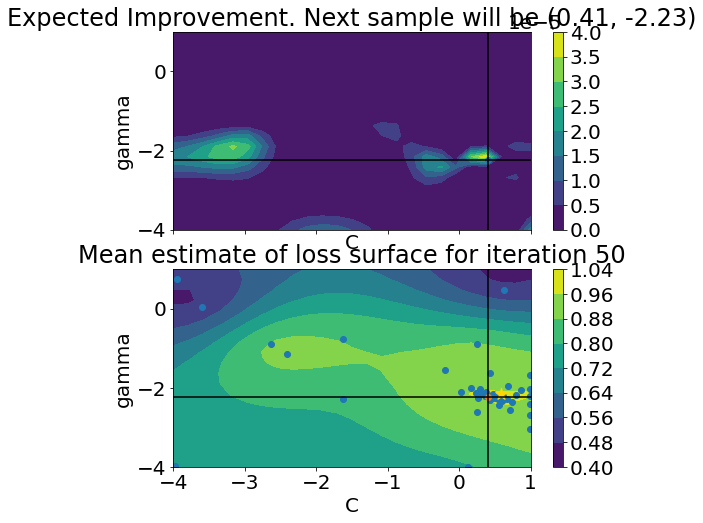

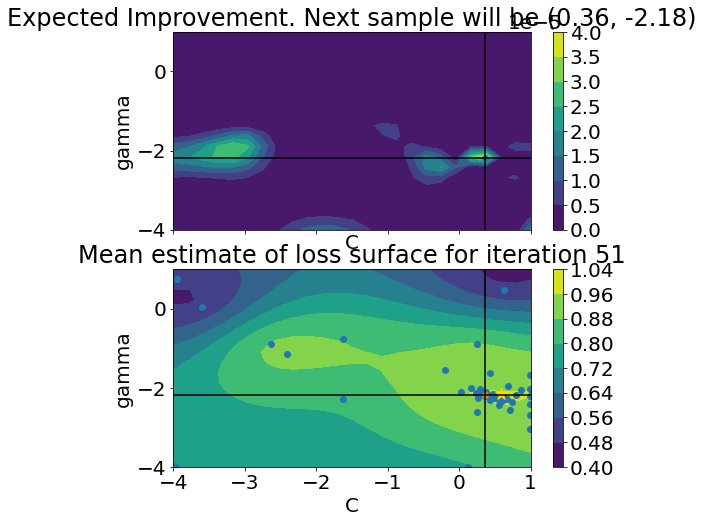

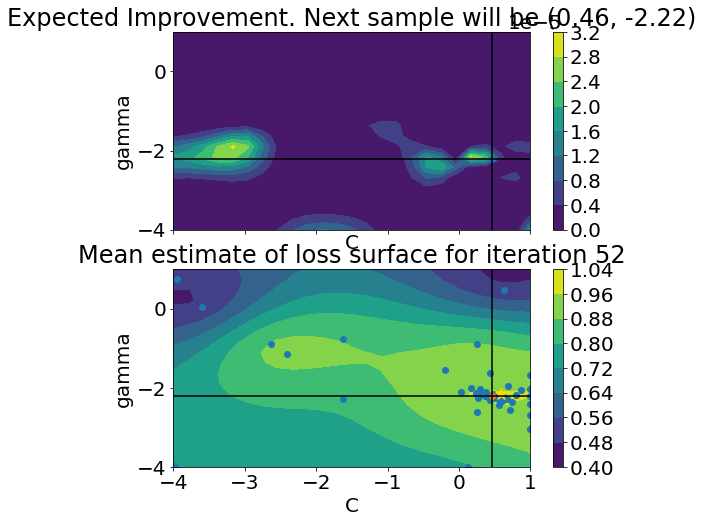

In [9]:
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.58333333, -2.15789474])

# References
<hr style = "border:2px solid black" ></hr>


- https://github.com/hamzafarooq/bayesian-optimization

